**APPLICATION OF DEEP LEARNING IN PREDICTING CURVES**

In [2]:
import warnings

from datetime import datetime

import pandas as pd
import numpy as np
import pandas_datareader.data as web

import seaborn as sns 

import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")

**1. Introduction**

- Yield curve is a graph showing interest rates (bonds) having different maturities. 

**Project Goal:** To find and understand the factors that affect movements pf yield curve. 
- Among the variables are the historical data of the yield curve, federal debt percentage that is held by the investors, and the corporate bond.
- The dependent variable will be the 1-month, 5-year and 30-year tenure of the yield curve.
- Data sources are FRED and Yahoo websites.
- The project uses polynomials of various degrees to forecast the yield curves.

**2. Understanding Data**

- Downloading the data:

In [3]:
# downloading the data
start = datetime(2007, 6, 30)
end = datetime(2022, 6, 30)

data = [
    "DGS1MO",
    "DGS3MO",
    "DGS1",
    "DGS2",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS30",
    "TREAST",  # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    "FYGFDPUN",  # -- Federal Debt Held by the Public ( Millions of Dollars )
    "FDHBFIN",  # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    "GFDEBTN",  # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    "BAA10Y",  # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()
data["FDHBFIN"] = data["FDHBFIN"] * 1000
data["GOV_PCT"] = data["TREAST"] / data["GFDEBTN"]
data["HOM_PCT"] = data["FYGFDPUN"] / data["GFDEBTN"]
data["FOR_PCT"] = data["FDHBFIN"] / data["GFDEBTN"]

- Defining the independent and dependent variables. We make an assumption that trading only happens on weekdays. As such, we calculate the lagged version of the variables using a 5 trading day lag. 

In [4]:
data.rename(
    columns = {
        "DGS1MO": "1m",
        "DGS3MO": "3m",
        "DGS1": "1y",
        "DGS2": "2y",
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y",
    },
    inplace=True,
)
return_period = 5

Y = data.loc[:, ["1m", "5y", "30y"]].shift(-return_period)
Y.columns = [col + "_pred" for col in Y.columns]

X = data.loc[
    :,
    [
        "1m",
        "3m",
        "1y",
        "2y",
        "5y",
        "7y",
        "10y",
        "30y",
        "GOV_PCT",
        "HOM_PCT",
        "FOR_PCT",
        "BAA10Y",
    ],
]

df = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = df.loc[:, Y.columns]
X = df.loc[:, X.columns]

df.head(10)

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2007-07-04,4.73,4.98,5.18,4.77,4.95,4.98,4.89,4.95,4.99,5.05,5.14,0.087765,0.56055,0.248156,1.60
2007-07-11,4.77,4.91,5.10,4.73,4.95,4.99,4.89,4.98,5.02,5.09,5.18,0.087770,0.56055,0.248156,1.59
2007-07-18,5.04,4.80,5.04,4.77,4.96,4.98,4.84,4.91,4.95,5.02,5.10,0.087776,0.56055,0.248156,1.58
2007-07-25,5.05,4.60,4.90,5.04,4.99,4.95,4.74,4.80,4.85,4.92,5.04,0.087782,0.56055,0.248156,1.65
2007-08-01,5.04,4.69,5.01,5.05,4.89,4.82,4.56,4.60,4.66,4.76,4.90,0.087792,0.56055,0.248156,1.86
2007-08-08,4.18,4.41,5.00,5.04,4.95,4.89,4.64,4.69,4.75,4.84,5.01,0.087794,0.56055,0.248156,1.87
2007-08-15,3.12,4.34,4.96,4.18,4.21,4.41,4.27,4.41,4.52,4.69,5.00,0.087659,0.56055,0.248156,2.03
2007-08-22,4.02,4.31,4.88,3.12,3.67,4.10,4.15,4.34,4.46,4.63,4.96,0.087661,0.56055,0.248156,2.07
2007-08-29,4.28,4.20,4.79,4.02,3.98,4.24,4.14,4.31,4.41,4.57,4.88,0.087108,0.56055,0.248156,2.05


**3. Exploratory Data Analysis (EDA)**

- With EDA, we understand the hidden structure of the data by visualizing trends, relationships, and patterns that would have escaped human eye. 
- We can start to draw conclusions from our data with EDA.

In [5]:
df.shape

(756, 15)

In [6]:
df.describe()

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.614828,1.738545,3.165886,0.619603,0.667989,0.867579,1.079921,1.740807,2.112513,2.449008,3.168307,0.111527,0.702420,0.303741,2.692606
std,0.955767,0.859650,0.885398,0.967441,0.978962,1.002382,0.945499,0.865833,0.850942,0.876473,0.888289,0.037446,0.059761,0.029200,0.771027
min,0.000000,0.210000,0.990000,0.000000,0.000000,0.040000,0.110000,0.210000,0.390000,0.540000,0.990000,0.042643,0.556527,0.242631,1.560000
25%,0.040000,1.145000,2.630000,0.040000,0.050000,0.150000,0.340000,1.145000,1.467500,1.840000,2.630000,0.091391,0.678839,0.287594,2.190000
50%,0.110000,1.650000,3.045000,0.110000,0.140000,0.370000,0.750000,1.650000,2.060000,2.370000,3.045000,0.111571,0.719631,0.304740,2.600000
75%,0.962500,2.282500,3.790000,0.962500,1.070000,1.492500,1.580000,2.282500,2.710000,2.960000,3.792500,0.130192,0.733350,0.330286,3.020000
max,5.050000,4.980000,5.180000,5.050000,4.990000,4.990000,4.890000,4.980000,5.020000,5.090000,5.180000,0.191040,0.786267,0.341355,6.110000


- Plotting the predicted variables to observe their behavior.

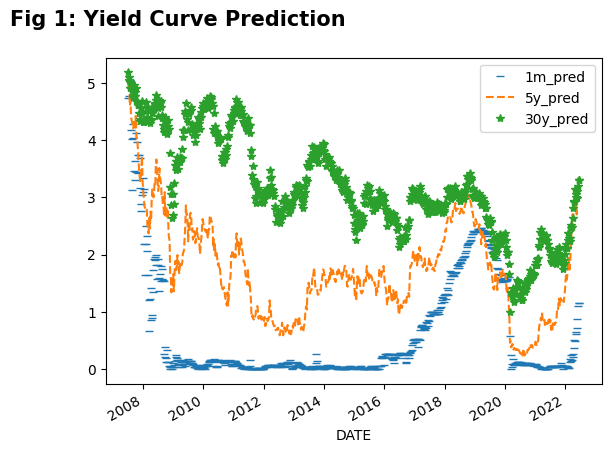

In [8]:
Y.plot(style=["_", "--","*"])
pyplot.suptitle(
    "Fig 1: Yield Curve Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15
)
pyplot.show()